In [1]:
from datasets import load_dataset, load_from_disk
from collections import Counter
import functools

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
%run PII_Util.py

# To Basy Py

In [4]:
def col_id2label_base(col_name, model_adapter):
    list_name = col_name.split('_')
    
    
    if list_name[-1].isdigit():
        label_id = int(list_name[-1])
        
        if list_name[0] == 'token':
            list_name[-1] = model_adapter.config.id2label[label_id]
        else:
            list_name[-1] = id2classes[label_id]
        return '_'.join(list_name)
        
    else:
        return col_name

In [5]:
def run_and_compute_metrics(path_dataset, path_preds, model_adapter):
    global df_all_metrics
    
    dataset = load_from_disk(path_dataset)
    np_preds = np.load(path_preds)
    np_labels = pad_lists(dataset['labels'], -100, np_preds.shape[1])
    
    threshold = model_adapter.threshold
    compute_metrics = functools.partial(compute_metrics_base, preprocessed_dataset=dataset, model_adapter=model_adapter, threshold=threshold)
    
    eval_preds = (np_preds, np_labels, None)
    dict_all_scores = compute_metrics(eval_preds)
    
    token_confusion_matrix = dict_all_scores.pop('token_confusion_matrix')
    word_confusion_matrix = dict_all_scores.pop('word_confusion_matrix')
    
    df_all_metrics = pd.DataFrame(dict_all_scores)
    
    col_id2label = functools.partial(col_id2label_base, model_adapter=model_adapter)
    df_all_metrics.columns = df_all_metrics.columns.map(col_id2label)
    df_all_metrics = df_all_metrics.T
    
    return df_all_metrics, token_confusion_matrix, word_confusion_matrix


# Model 1

## Data

In [6]:
%%time
threshold = 0.18
model_adapter_1 = Yanis_Adapter(threshold = threshold, config_only=True, will_bio_tokens=False, will_bio_words=True)
path_dataset_1 = "./in/tokenized_datasets"
path_preds_1 = "./in/preds01.npy"


# preprocessed_dataset = load_from_disk("./in/preprocessed_dataset_2")

CPU times: total: 844 ms
Wall time: 1.94 s


In [7]:
%%time
df_all_metrics_1, token_confusion_matrix_1,  word_confusion_matrix_1 = run_and_compute_metrics(path_dataset_1, path_preds_1, model_adapter_1)

CPU times: total: 1min 5s
Wall time: 1min 29s


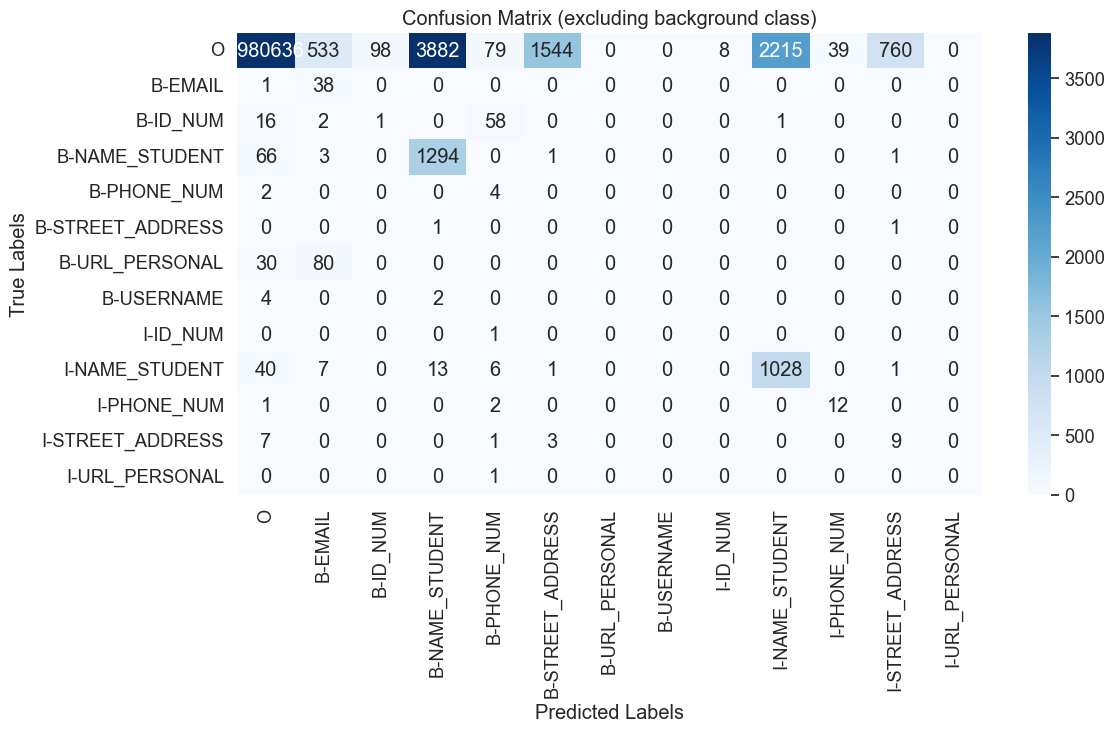

In [8]:
conf_matrix = word_confusion_matrix_1

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

# Model 2

In [9]:
%%time
threshold = 0.01
model_adapter_2 = Yanis_Adapter(threshold = threshold, checkpoint_path='./fine_tuned/yanis/yanis_01',  config_only=True, will_bio_tokens=False, will_bio_words=True)
path_dataset_2 = "./in/preprocessed_dataset_2"
path_preds_2 = ("./in/preds02.npy")


Yanis_Adapter(threshold = 0.1, checkpoint_path='./fine_tuned/yanis/yanis_01',  config_only=True, will_bio_tokens=False, will_bio_words=True)
# preprocessed_dataset = load_from_disk("./in/preprocessed_dataset_2")

CPU times: total: 828 ms
Wall time: 1.49 s


In [10]:
%%time
df_all_metrics_2, token_confusion_matrix_2,  word_confusion_matrix_2 = run_and_compute_metrics(path_dataset_2, path_preds_2, model_adapter_2)

CPU times: total: 1min 2s
Wall time: 1min 20s


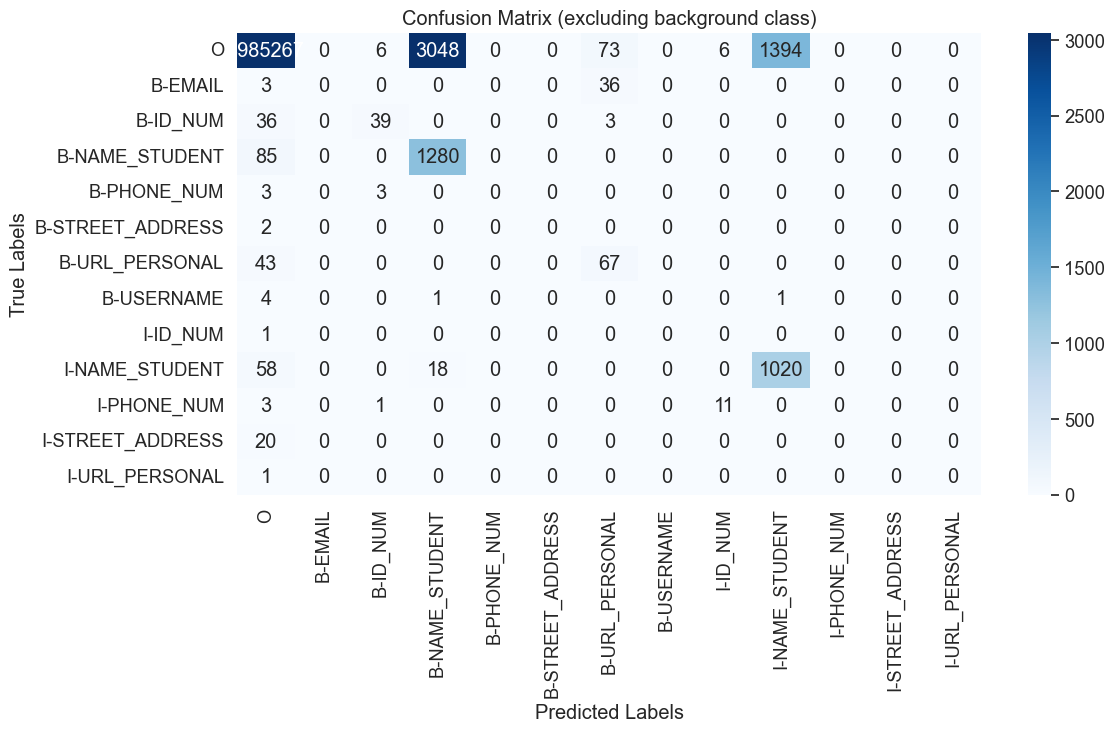

In [11]:
conf_matrix = word_confusion_matrix_2

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Calculate vmin and vmax excluding the background class
vmin = np.min(conf_matrix[conf_matrix != conf_matrix[0,0]])
vmax = np.max(conf_matrix[conf_matrix != conf_matrix[0,0]])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (excluding background class)')
plt.show()

# Comparison

## Confusion matrix diff

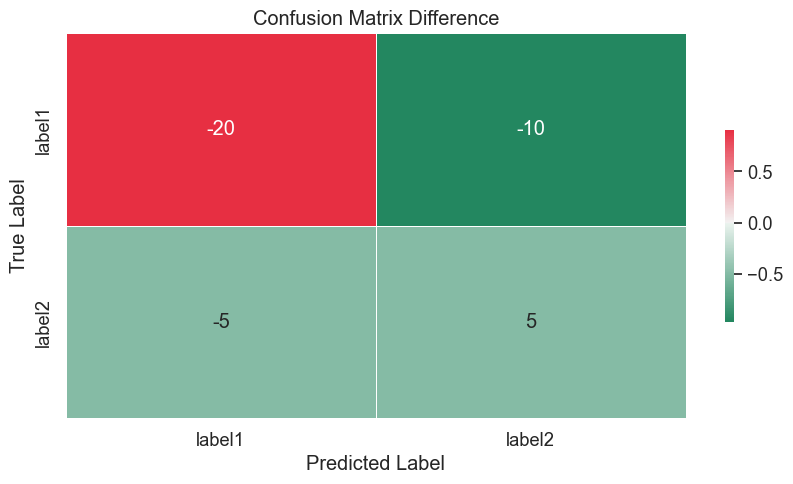

<Axes: title={'center': 'Confusion Matrix Difference'}, xlabel='Predicted Label', ylabel='True Label'>

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_diff_matrix(diff_cm, labels, fmt="d", pos_labels = None, invert_diagonal = True, invert_colors = True, robust=True):
    # Create a copy of the difference matrix to invert the signs of diagonal elements
    
    if invert_diagonal:
        diff_cm_visual = np.copy(diff_cm)
        np.fill_diagonal(diff_cm_visual, -np.diagonal(diff_cm))
    else:
        diff_cm_visual = diff_cm
        
        
    if pos_labels:
        inverse_labels = np.setdiff1d(list(range(diff_cm.shape[0])), pos_labels)
        
        diff_cm_visual[inverse_labels, :] = 0
        diff_cm_visual[:, inverse_labels] = 0
        
    positive_values = np.where(diff_cm_visual > 0, diff_cm_visual, 0)
    negative_values = np.where(diff_cm_visual < 0, diff_cm_visual, 0)

    # Normalize positive values to range [0, 1]
    max_positive = np.max(positive_values)
    positive_normalized = np.where(positive_values > 0, positive_values / max_positive, 0)

    # Normalize negative values to range [0, -1]
    min_negative = np.min(negative_values)
    negative_normalized = np.where(negative_values < 0, negative_values / min_negative, 0)

    # Combine positive, negative, and zero values
    data_normalized = positive_normalized - negative_normalized
    
    # Set up the color mapping
#     cmap = sns.diverging_palette(150, 10, as_cmap=True)

    if invert_colors:
        cmap = sns.diverging_palette(150, 10, s=90, l=50, as_cmap=True)
    else:
        cmap = sns.diverging_palette(10, 150, s=90, l=50, as_cmap=True)
    
    # Set up the figure
    plt.figure(figsize=(10, 5))
    
    # Plot the heatmap for the difference matrix with specified color mapping
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center=0,
#                 linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center = 0,
#             linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
#     obj = sns.heatmap(diff_cm_visual, annot=diff_cm, robust=True, fmt="d", cmap=cmap, center=0, vmin = -799, vmax=100,
#             linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)

#     obj = sns.heatmap(data_normalized, annot=diff_cm, robust=False, fmt="d", cmap=cmap, center=0, vmin = -1, vmax =1,
#         linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
    obj = sns.heatmap(data_normalized, annot=diff_cm, robust=robust, fmt=fmt, cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    
    
    
    plt.title('Confusion Matrix Difference')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return obj
    

# Example confusion matrices (replace these with your actual confusion matrices)
cm1 = np.array([[120, 20], [30, 50]])
cm2 = np.array([[100, 10], [25, 55]])

diff_cm = cm2 - cm1

visualize_diff_matrix(diff_cm, ['label1', 'label2'])

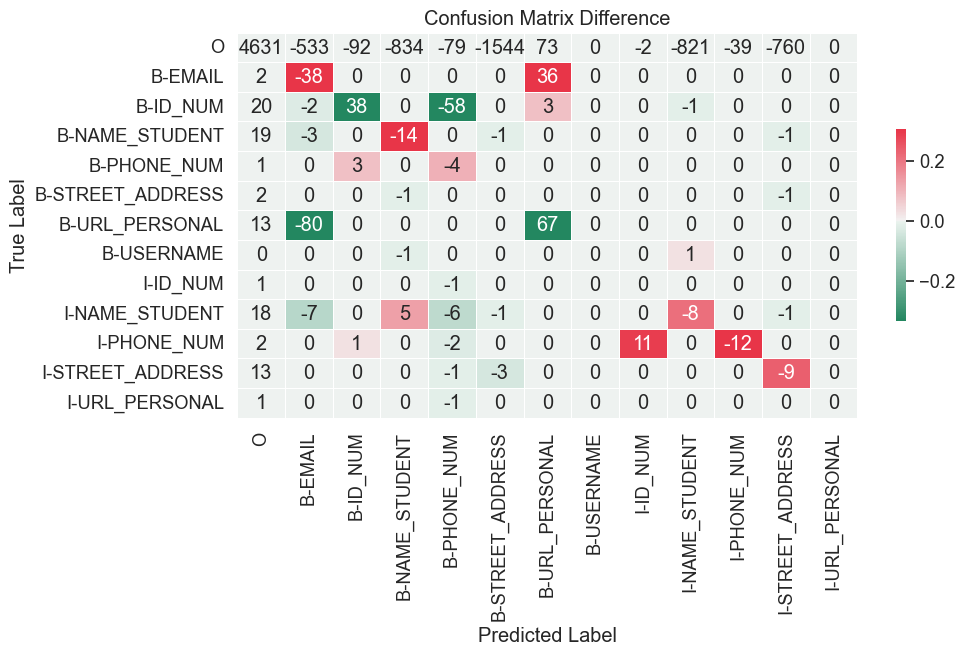

In [13]:
diff_cm = word_confusion_matrix_2 - word_confusion_matrix_1
obj = visualize_diff_matrix(diff_cm, classes, pos_labels = classes_pos_id)

## Metric contribution

In [14]:
def calculate_total_f_beta(cm, pos_labels, beta=5):
    # Calculate precision and recall across all classes
    global TP, FP, FN
    
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    # Compute total precision excluding 'O' label
    total_precision = total_tp / (total_tp + total_fp) if total_tp + total_fp > 0 else 0
    
    # Compute total recall excluding 'O' label
    total_recall = total_tp / (total_tp + total_fn) if total_tp + total_fn > 0 else 0
    
    # Compute total F-beta score excluding 'O' label
    total_f_beta = (1 + beta**2) * (total_precision * total_recall) / (beta**2 * total_precision + total_recall) if total_precision + total_recall > 0 else 0
    
    return total_f_beta


def get_cell_contribution_matrix(cm1, cm2, pos_labels, beta=1):
    f_beta_score_cm1 = calculate_total_f_beta(cm1,pos_labels, beta)
    
    compute_micro_metrics
    
    cell_contribution_matrix = np.zeros_like(cm1, dtype=float)
    
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            # Temporarily modify the corresponding cell in cm1 to match cm2
            cm1_modified = cm1.copy()
            cm1_modified[i, j] = cm2[i, j]
            
            # Calculate the total F-beta score for modified cm1
            f_beta_score_modified = calculate_total_f_beta(cm1_modified, pos_labels,beta)
            
            # Calculate the contribution of changing the current cell
            cell_contribution_matrix[i, j] = f_beta_score_modified - f_beta_score_cm1
    
    return cell_contribution_matrix

# Example usage
cm1 = np.array([[10, 5, 3],
                [2, 20, 1],
                [1, 3, 15]])

cm2 = np.array([[12, 6, 2],
                [1, 21, 1],
                [2, 2, 16]])

num_classes = cm1.shape[0]

contribution_matrix = get_cell_contribution_matrix(cm1, cm2, pos_labels=list(range(num_classes)), beta=1)
print("Contribution Matrix:")
print(contribution_matrix)

Contribution Matrix:
[[ 0.00806452 -0.01229508  0.01271186]
 [ 0.01271186  0.00409836  0.        ]
 [-0.01229508  0.01271186  0.00409836]]


In [15]:
cont_matrix = get_cell_contribution_matrix(word_confusion_matrix_1, word_confusion_matrix_2, pos_labels=classes_pos_id,beta=5)

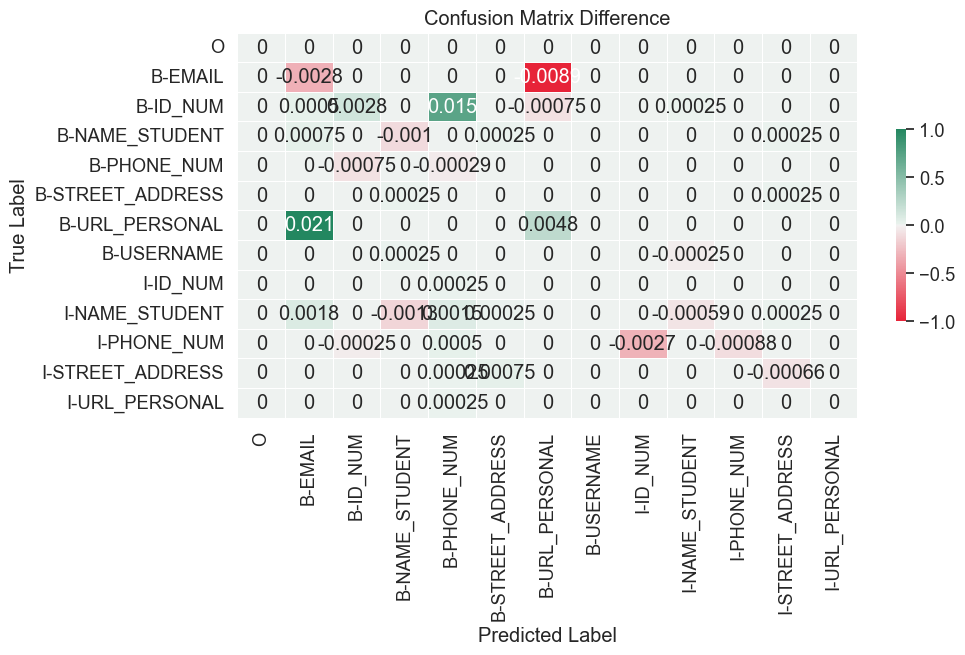

<Axes: title={'center': 'Confusion Matrix Difference'}, xlabel='Predicted Label', ylabel='True Label'>

In [16]:
visualize_diff_matrix(cont_matrix, classes, fmt = '.2g', invert_diagonal=False, invert_colors=False, robust=False, pos_labels=classes_pos_id)

## Class based summaries

In [24]:
def calculate_f_beta(tp, fp, fn, beta):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta


def compute_f_beta_contributions(cm1, cm2, pos_labels, beta=5):
    diff_cm = cm2 - cm1
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 4))  # 3 columns for TP, FP, FN

    # Calculate the original F-beta score for the entire multiclass classification model using cm1
    tp_orig = np.diag(cm1)
    fp_orig = np.sum(cm1, axis=0) - tp_orig
    fn_orig = np.sum(cm1, axis=1) - tp_orig
    

    total_tp = sum(tp_orig[pos_labels])
    total_fp = sum(fp_orig[pos_labels])
    total_fn = sum(fn_orig[pos_labels])
    
    original_f_beta = calculate_f_beta(total_tp, total_fp, total_fn, beta)

    # Calculate contributions for changes in TP, FP, and FN separately
    for i in range(1, n_classes):
        # Simulate changes in TP, FP, and FN while keeping other metrics constant
        tp_change = diff_cm[i, i]
#         fp_change = np.sum(diff_cm[1, i]) - tp_change
#         fn_change = np.sum(diff_cm[i, :]) - tp_change
        fp_change = np.sum(diff_cm[pos_labels, i]) - tp_change
        fn_change = np.sum(diff_cm[i, pos_labels]) - tp_change
        # Calculate contributions for TP, FP, and FN separately
        
        f_beta_tp = calculate_f_beta(total_tp + tp_change, total_fp, total_fn, beta)
        f_beta_fp = calculate_f_beta(total_tp, total_fp + fp_change, total_fn, beta)
        f_beta_fn = calculate_f_beta(total_tp, total_fp, total_fn + fn_change, beta)
        f_beta_class = calculate_f_beta(total_tp + tp_change, total_fp + fp_change, total_fn + fn_change, beta)
        
                
        # Calculate contributions by subtracting original F-beta score
        f_beta_contributions[i] = [
            f_beta_tp - original_f_beta,
            f_beta_fp - original_f_beta,
            f_beta_fn - original_f_beta,
            f_beta_class - original_f_beta
        ]

    return f_beta_contributions

# Example confusion matrices
cm1 = np.array([
    [50, 5, 10],   # Class 0
    [7, 60, 20],   # Class 1
    [15, 20, 70]   # Class 2
])

cm2 = np.array([
    [60, 10, 5],   # Class 0
    [8, 60, 19],   # Class 1
    [14, 21, 70]   # Class 2
])

# Parameters
beta = 1
class_index = 1  # Class index of interest (e.g., 0, 1, 2)

# Compute contributions for the specified class
f_beta_contributions = compute_f_beta_contributions(cm1, cm2, pos_labels= [0,1,2], beta=beta)
print(f"F-beta contributions for class {class_index} (TP, FP, FN):")
print(f_beta_contributions)

F-beta contributions for class 1 (TP, FP, FN):
[[ 0.          0.          0.          0.        ]
 [ 0.         -0.00808141  0.         -0.00808141]
 [ 0.          0.00827231  0.          0.00827231]]


In [27]:
cont_class_matrix = compute_f_beta_contributions(word_confusion_matrix_1, word_confusion_matrix_2, pos_labels=classes_pos_id,beta=5)

In [28]:
cont_class_matrix.sum()

0.05993249271731482

In [29]:
cont_class_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.82532320e-03,  8.88233557e-04, -8.58296270e-03,
        -1.06063825e-02],
       [ 2.75656310e-03, -3.85726284e-05,  1.42407286e-02,
         1.68313333e-02],
       [-1.03277329e-03, -2.89298320e-05,  1.20733640e-03,
         1.49342595e-04],
       [-2.94120288e-04,  6.65983967e-04, -7.22597149e-04,
        -3.52030873e-04],
       [ 0.00000000e+00,  4.82211963e-05,  4.82482682e-04,
         5.30764059e-04],
       [ 4.81553644e-03, -3.75919091e-04,  1.97805252e-02,
         2.38965505e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.06065472e-04,  2.41166123e-04,
         1.35034503e-04],
       [-5.89005318e-04,  0.00000000e+00,  2.41844784e-03,
         1.83390395e-03],
       [-8.84658076e-04,  0.00000000e+00, -2.40341802e-03,
        -3.29467308e-03],
       [-6.62846416e-04,  2.89319963e-05,  9.65567678e-04,
      

<Axes: >

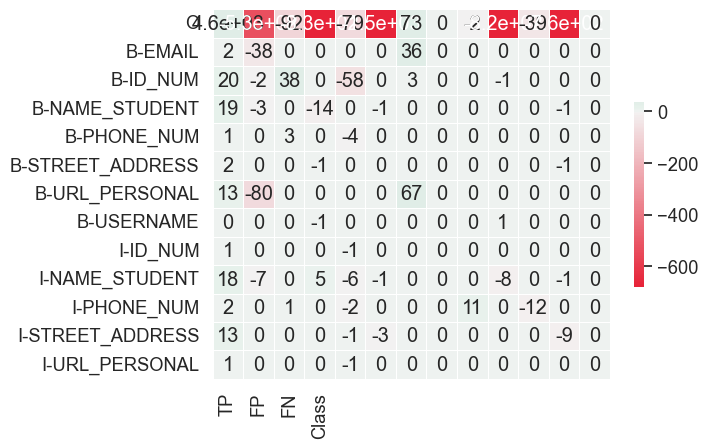

In [30]:
cmap = sns.diverging_palette(10, 150, s=90, l=50, as_cmap=True)

sns.heatmap(diff_cm, annot=diff_cm, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN', 'Class'])
    

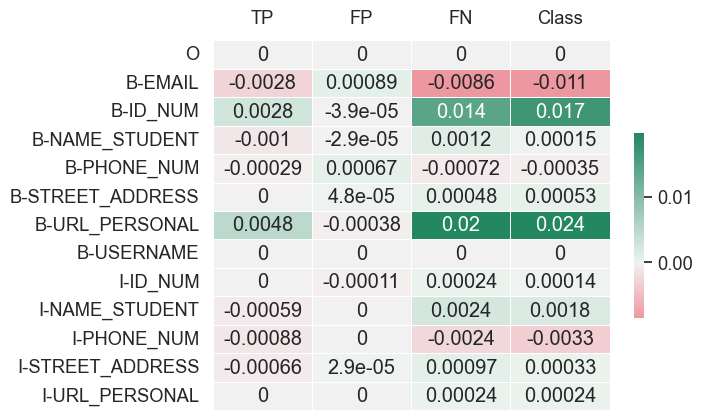

In [31]:
cmap = sns.diverging_palette(10, 150, s=90, l=50, as_cmap=True)

sns.heatmap(cont_class_matrix, annot=cont_class_matrix, robust=True, fmt='.2g', cmap=cmap, center=0,
        linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=classes, xticklabels=['TP','FP','FN', 'Class'])


plt.tick_params(labelbottom = False, labeltop=True)
plt.show()
    

## Stats changes

In [ ]:
#How to get most significant changes?
# - Ratio of change
# - Flat Change amount
# - 

#Which results?
# - Top 5 positive
# - Top 5 Negative

#Old and New
# - 
# -

In [54]:

df_all_diff = (df_all_metrics_2 - df_all_metrics_1).dropna()
df_all_diff['max_val'] = df_all_diff[['precision', 'recall', 'f_beta']].max(axis=1)
df_all_diff['min_val'] = df_all_diff[['precision', 'recall', 'f_beta']].min(axis=1)
df_all_diff['max_mag'] = df_all_diff[['max_val', 'min_val']].apply(lambda row: max(row.max_val, abs(row.min_val)),axis=1)
df_all_diff.sort_values('max_mag', ascending=False)
# .sort_values('f_beta', ascending=False)

,precision,recall,f_beta,tp,fp,fn,max_val,min_val,max_mag
word_B-EMAIL,-0.057315,-0.974359,-0.603175,-38.0,-625.0,38.0,-0.057315,-0.974359,0.974359
word_I-PHONE_NUM,-0.235294,-0.800000,-0.732394,-12.0,-39.0,12.0,-0.235294,-0.800000,0.800000
word_B-ID_NUM,0.785817,0.487179,0.494565,38.0,-88.0,-38.0,0.785817,0.487179,0.785817
word_B-PHONE_NUM,-0.026316,-0.666667,-0.344371,-4.0,-148.0,4.0,-0.026316,-0.666667,0.666667
word_B-URL_PERSONAL,0.374302,0.609091,0.594742,67.0,112.0,-67.0,0.609091,0.374302,0.609091
word_I-STREET_ADDRESS,-0.011658,-0.450000,-0.183962,-9.0,-763.0,9.0,-0.011658,-0.450000,0.450000
token_total_metrics,0.178770,-0.192024,-0.096028,543.0,-9464.0,1395.0,0.178770,-0.192024,0.192024
word_total_metrics,0.139961,0.007302,0.055286,20.0,-4743.0,-20.0,0.139961,0.007302,0.139961
word_I-NAME_STUDENT,0.105468,-0.007299,0.017275,-8.0,-821.0,8.0,0.105468,-0.007299,0.105468
word_B-NAME_STUDENT,0.045226,-0.010256,0.009333,-14.0,-831.0,14.0,0.045226,-0.010256,0.045226


In [82]:
df_all_diff.sort_values('min_val', ascending=True)[:5]

,precision,recall,f_beta,tp,fp,fn,max_val,min_val,max_mag
word_B-EMAIL,-0.057315,-0.974359,-0.603175,-38.0,-625.0,38.0,-0.057315,-0.974359,0.974359
word_I-PHONE_NUM,-0.235294,-0.800000,-0.732394,-12.0,-39.0,12.0,-0.235294,-0.800000,0.800000
word_B-PHONE_NUM,-0.026316,-0.666667,-0.344371,-4.0,-148.0,4.0,-0.026316,-0.666667,0.666667
word_I-STREET_ADDRESS,-0.011658,-0.450000,-0.183962,-9.0,-763.0,9.0,-0.011658,-0.450000,0.450000
token_total_metrics,0.178770,-0.192024,-0.096028,543.0,-9464.0,1395.0,0.178770,-0.192024,0.192024


In [122]:
def print_min(row):
    id_min = row[['precision', 'recall', 'f_beta']].idxmin()
    id_val = row[id_min]
    if id_min != 'f_beta':
            print(f'{row.name}: {id_min} reduced: {id_val} -> f_beta change: {row.f_beta}')
    else:
        print(f'{row.name}: {id_min} reduced: {id_val}')

In [123]:
def print_max(row):
    id_max = row[['precision', 'recall', 'f_beta']].idxmax()
    id_val = row[id_max]
    if id_max != 'f_beta':
        print(f'{row.name}: {id_max} increased: {id_val} -> f_beta change: {row.f_beta}')
    else:
        print(f'{row.name}: {id_max} increased: {id_val}')

In [128]:
df_all_diff.sort_values('max_val', ascending=False).iloc[:7,:].apply(print_max, axis=1);

word_B-ID_NUM: precision increased: 0.7858173572459287 -> f_beta change: 0.49456451017114217
word_B-URL_PERSONAL: recall increased: 0.6090909090909091 -> f_beta change: 0.5947422328439741
token_total_metrics: precision increased: 0.1787704272703341 -> f_beta change: -0.09602839455135137
word_total_metrics: precision increased: 0.1399608551234419 -> f_beta change: 0.05528588681601687
word_I-NAME_STUDENT: precision increased: 0.10546752341637883 -> f_beta change: 0.017275264207599172
word_B-NAME_STUDENT: precision increased: 0.04522636265451299 -> f_beta change: 0.009333437905342579
token_O: recall increased: 0.002037648356459365 -> f_beta change: 0.0019498337807245525


In [127]:
df_all_diff.sort_values('min_val', ascending=True).iloc[:7,:].apply(print_min, axis=1);

word_B-EMAIL: recall reduced: -0.9743589743589743 -> f_beta change: -0.6031746031746031
word_I-PHONE_NUM: recall reduced: -0.8 -> f_beta change: -0.7323943661971832
word_B-PHONE_NUM: recall reduced: -0.6666666666666666 -> f_beta change: -0.3443708609271523
word_I-STREET_ADDRESS: recall reduced: -0.45 -> f_beta change: -0.1839622641509434
token_total_metrics: recall reduced: -0.19202435987180377 -> f_beta change: -0.09602839455135137
word_B-NAME_STUDENT: recall reduced: -0.01025641025641022 -> f_beta change: 0.009333437905342579
word_I-NAME_STUDENT: recall reduced: -0.007299270072992692 -> f_beta change: 0.017275264207599172


# Unify Metrics

Code Duplications
 - f_beta_from_conf uses logic from
   - count_confusion_matrix
 - parts of f_beta_from_conf logic is used in 
   - compute_f_beta_contributions 
   - compute_micro_metrics
   
Compute duplications:
 - To save compute reuse tp,fp,fn from compute_micro_metrics (total and class-based) 
   - compute_f_beta_contributions
   - get_cell_contribution_matrix


## Base

In [ ]:
def count_confusion_matrix(predictions, labels, num_classes):
    """
    Count confusion matrix per class ID.
    
    Args:
    - predictions: NumPy array of predicted class labels (shape: [N]).
    - labels: NumPy array of ground truth class labels (shape: [N]).
    - num_classes: Number of classes.
    
    Returns:
    - TP: NumPy array of True Positives per class ID.
    - TN: NumPy array of True Negatives per class ID.
    - FN: NumPy array of False Negatives per class ID.
    - FP: NumPy array of False Positives per class ID.
    """
        
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    np.add.at(confusion_matrix, (labels, predictions), 1)
    
    # True Positives (TP)
    TP = np.diag(confusion_matrix)
    
    # True Negatives (TN) / Omit to save compute
    #TN = np.sum(confusion_matrix) - np.sum(confusion_matrix[np.eye(num_classes, dtype=bool)])
    TN = None
    
    # False Positives (FP)
    FP = np.sum(confusion_matrix, axis=0) - TP
    
    # False Negatives (FN)
    FN = np.sum(confusion_matrix, axis=1) - TP

    return confusion_matrix, TP, TN, FP, FN


def f_beta_from_counts(tp, fp, fn, beta, return_all=False):
    precision = tp / (tp + fp) if tp + fp > 0 else 0 
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if precision + recall > 0 else 0
    
    if return_all:
        return f_beta, precision, recall
    
    return f_beta




## L2 Compute_Metrics

In [ ]:
def compute_metrics_per_class(TP, FP, FN, class_label, beta=5):
    
    tp = TP[class_label]
    fp = FP[class_label]
    fn = FN[class_label]

    f_beta, precision, recall = f_beta_from_counts(tp, fp, fn, beta, return_all = True)
    metrics = {'precision':precision, 'recall':recall, 'f_beta':f_beta,'tp':tp, 'fp':fp, 'fn':fn}
    
    return metrics

def compute_micro_metrics(predictions, labels, num_classes, pos_labels, prefix='', beta=5):
#     global class_metrics
    
    confusion_matrix, TP, TN, FP, FN = count_confusion_matrix(predictions = predictions, labels = labels, num_classes = num_classes)
    
    class_metrics = {f'{prefix}{class_label}':compute_metrics_per_class(TP, FP, FN, class_label, beta=beta) for class_label in range(num_classes)}
#     class_metrics = {key:value for class_label in range(num_classes) for key,value in compute_metrics_per_class(TP, FN, FP, class_label, beta=beta, prefix=prefix).items()}
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    # Compute total precision excluding 'O' label
    total_f_beta, total_precision, total_recall = f_beta_from_counts(total_tp, total_fp, total_fn, beta, return_all = True)
    
    total_metrics = {'precision':total_precision, 'recall':total_recall, 'f_beta':total_f_beta,'tp':total_tp, 'fp':total_fp, 'fn':total_fn}
    
    return total_metrics, class_metrics, confusion_matrix
    
    

## L2 Comparisons

In [ ]:
def f_beta_from_conf(cm, pos_labels, beta=5, return_all = False):
    # Calculate precision and recall across all classes
    global TP, FP, FN
    
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    
    # Calculate total true positives, false positives, and false negatives excluding 'O' label
    total_tp = sum(TP[pos_labels])
    total_fp = sum(FP[pos_labels])
    total_fn = sum(FN[pos_labels])
    
    return f_beta_from_counts(total_tp, total_fp, total_fn, beta, return_all = return_all)
  


### L3

In [ ]:
# By Cell
def get_cell_contribution_matrix(cm1, cm2, pos_labels, beta=1):
    f_beta_score_cm1 = f_beta_from_conf(cm1,pos_labels, beta) 
    
    cell_contribution_matrix = np.zeros_like(cm1, dtype=float)
    
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            # Temporarily modify the corresponding cell in cm1 to match cm2
            cm1_modified = cm1.copy()
            cm1_modified[i, j] = cm2[i, j]
            
            # Calculate the total F-beta score for modified cm1
            f_beta_score_modified = f_beta_from_conf(cm1_modified, pos_labels,beta)
            
            # Calculate the contribution of changing the current cell
            cell_contribution_matrix[i, j] = f_beta_score_modified - f_beta_score_cm1
    
    return cell_contribution_matrix


#By Class

def compute_f_beta_contributions(cm1, cm2, pos_labels, beta=5):
    diff_cm = cm2 - cm1
    n_classes = cm1.shape[0]
    f_beta_contributions = np.zeros((n_classes, 4))  # 3 columns for TP, FP, FN

    # Calculate the original F-beta score for the entire multiclass classification model using cm1
    tp_orig = np.diag(cm1)
    fp_orig = np.sum(cm1, axis=0) - tp_orig
    fn_orig = np.sum(cm1, axis=1) - tp_orig
    
    total_tp = sum(tp_orig[pos_labels])
    total_fp = sum(fp_orig[pos_labels])
    total_fn = sum(fn_orig[pos_labels])
    
    original_f_beta = f_beta_from_counts(total_tp, total_fp, total_fn, beta)

    # Calculate contributions for changes in TP, FP, and FN separately
    for i in range(1, n_classes):
        # Simulate changes in TP, FP, and FN while keeping other metrics constant
        tp_change = diff_cm[i, i]
        fp_change = np.sum(diff_cm[pos_labels, i]) - tp_change
        fn_change = np.sum(diff_cm[i, pos_labels]) - tp_change
        # Calculate contributions for TP, FP, and FN separately
        
        f_beta_tp = f_beta_from_counts(total_tp + tp_change, total_fp, total_fn, beta)
        f_beta_fp = f_beta_from_counts(total_tp, total_fp + fp_change, total_fn, beta)
        f_beta_fn = f_beta_from_counts(total_tp, total_fp, total_fn + fn_change, beta)
        f_beta_class = f_beta_from_counts(total_tp + tp_change, total_fp + fp_change, total_fn + fn_change, beta)
               
        # Calculate contributions by subtracting original F-beta score
        f_beta_contributions[i] = [
            f_beta_tp - original_f_beta,
            f_beta_fp - original_f_beta,
            f_beta_fn - original_f_beta,
            f_beta_class - original_f_beta
        ]

    return f_beta_contributions


# Manual

In [36]:
df_all_metrics_1.loc['word_total_metrics']

precision       0.203410
recall          0.871121
f_beta          0.773468
tp           2386.000000
fp           9344.000000
fn            353.000000
Name: word_total_metrics, dtype: float64

In [37]:
df_all_metrics_2.loc['word_total_metrics']

precision       0.343371
recall          0.878423
f_beta          0.828754
tp           2406.000000
fp           4601.000000
fn            333.000000
Name: word_total_metrics, dtype: float64

# Bin